# Problem Setup
https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html

**Diffusion equation**

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

### Initial Condition:

$$y(x,0)=sin(\pi x)$$

### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

### Exact solution:

$$y(x,t)=e^{-t}sin(\pi x)$$

# Analysis:
## PDE
$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

If we rearrange our PDE, we get:

$$\left(\frac{\partial y}{\partial t} -\frac{\partial^2 y}{\partial x^2}\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))=0$$

## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset(known data).
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$NN(x,t)\approx y(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\frac{\partial^2 NN}{\partial x^2}$.(Automatic Diferentiation) 

Assume:$$NN(t,x)\approx y(t,x)$$ 

Then:

$$\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))\approx \left(\frac{\partial y}{\partial t} -\frac{\partial^2 y}{\partial x^2}\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))=0$$

And:

$$\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))\approx 0$$


We define this function as $f$:

$$f(t,x)=\left(\frac{\partial NN}{\partial t} -\frac{\partial^2 NN}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

If $f\rightarrow 0$ then our NN would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_f$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

#### Initial Condition:

$$y(x,0)=sin(\pi x)$$

#### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN(t_{u}^i,x_u^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

# Problem Setup
https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html

**Diffusion equation**

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

### Initial Condition:

$$y(x,0)=sin(\pi x)$$

### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

### Exact solution:

$$y(x,t)=e^{-t}sin(\pi x)$$

In [142]:
import tensorflow as tf
import numpy as np

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Set Constants

pi = tf.constant(np.pi, dtype = DTYPE)


# Define I.C.
def fun_u_0(x):
    return tf.sin(pi * x)

# Define B.C.
def fun_u_b(x, t):
    n = x.shape[0]
    return tf.zeros((n, 1), dtype = DTYPE)

# Define Residual of the PDE:
def fun_r(x, u, t, u_t, u_x, u_xx):
    return u_t - u_xx + tf.exp(-t) * (tf.sin(pi *x) - pi**2*tf.sin(pi*x))

In [143]:
# Set number of data points
N_0 = 50
N_b = 50

N_r = 10000

# Set Boundary
tmin = 0
tmax = 1
xmin = -1
xmax = 1


# Lower Bound
lb = tf.constant([xmin, tmin], dtype = DTYPE)

# Upper Bound
ub = tf.constant([xmax, tmax], dtype = DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0, 1), dtype = DTYPE) * lb[1]
x_0 = tf.random.uniform((N_0, 1), lb[0], ub[0], dtype = DTYPE)
X_0 = tf.concat([x_0, t_0], axis = 1)


# Evaluate initial condition at x_0 ==> applying np.sin(pi*x) for every point at t = 0
u_0 = fun_u_0(x_0)

# Boundary data 
t_b = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype = DTYPE)
x_b = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype = DTYPE)
X_b = tf.concat([t_b, x_b], axis = 1)

# Evaluate Boundary condition at (t_b, x_b)
u_b = fun_u_b(x_b, t_b)  #boundary = 0

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = DTYPE)
x_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = DTYPE)
X_r = tf.concat([x_r, t_r], axis = 1)

# Collect boundary and initial data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]


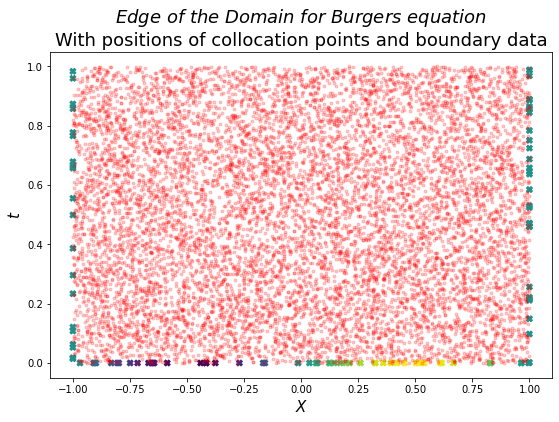

In [144]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (9, 6))
plt.scatter(x_0, t_0, c = u_0, marker = 'X', vmin = -1, vmax = 1)
plt.scatter(x_b, t_b, c = u_b, marker = 'X', vmin = -1, vmax = 1)
plt.scatter(x_r, t_r, c = 'r', marker = '.', alpha = 0.2)

plt.xlabel('$X$', fontsize = 15)
plt.ylabel('$t$', fontsize = 15)
plt.title('$Edge$ $of$ $the$ $Domain$ $for$ $Burgers$ $equation$\n\
With positions of collocation points and boundary data', fontsize = 18)
plt.show()



### 3. Set up network architecture

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3021$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [145]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [146]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x, t = X_r[:, 0:1], X_r[:,1:2]     #for [:, 0] is the row vector , while using [:, 0:1] will become column vector

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x)
        tape.watch(t)

        # Determine residual 
        u = model(tf.stack([x[:,0], t[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape
    
    return fun_r(x, u, t, u_t, u_x, u_xx)

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [147]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [148]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

## Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model.

In [149]:
# Initialize model aka u_theta

model = init_model()
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])

# Choose the optimizers
optim = tf.keras.optimizers.Adam(learning_rate = lr)

In [150]:
from time import time

# Define one training step as a Tensorflow function to increase speed of training 
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start time 
t0 = time()
for i in range(N+1):
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if  i%50 ==0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))
        

print('\nComputation time : {} seconds'.format(time()- t0))

It 00000: loss = 1.90988445e+01
It 00050: loss = 3.44128132e-01
It 00100: loss = 1.15302205e-01
It 00150: loss = 3.52475867e-02
It 00200: loss = 3.01283821e-02
It 00250: loss = 2.71952488e-02
It 00300: loss = 3.80164161e-02
It 00350: loss = 2.35530920e-02
It 00400: loss = 3.63615006e-02
It 00450: loss = 1.87126882e-02
It 00500: loss = 2.56102514e-02
It 00550: loss = 3.88275236e-02
It 00600: loss = 1.55423805e-02
It 00650: loss = 2.28175260e-02
It 00700: loss = 4.96932082e-02
It 00750: loss = 5.59579358e-02
It 00800: loss = 1.72319487e-02
It 00850: loss = 2.25422084e-02
It 00900: loss = 2.30284873e-02
It 00950: loss = 1.96951590e-02
It 01000: loss = 3.12861763e-02
It 01050: loss = 1.10846311e-02
It 01100: loss = 1.08716320e-02
It 01150: loss = 1.08055398e-02
It 01200: loss = 1.07547184e-02
It 01250: loss = 1.07083619e-02
It 01300: loss = 1.06637720e-02
It 01350: loss = 1.06198974e-02
It 01400: loss = 1.05763450e-02
It 01450: loss = 1.05328914e-02
It 01500: loss = 1.04894191e-02
It 01550

Text(0.5, 0.92, 'Solution of Diffusion equation')

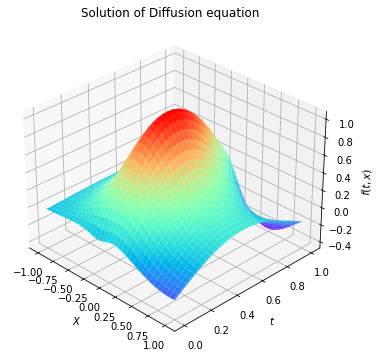

In [154]:
#from mpl_toolkit.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Set up meshgrid
N = 100
xspace = np.linspace(lb[0], ub[0], N+1)
tspace = np.linspace(lb[1], ub[1], N+1)
X, T = np.meshgrid(xspace, tspace)

Xgrid = np.vstack([T.flatten(), X.flatten()]).T

# Determine predicitons of u(x,t)
upred = model(tf.cast(Xgrid, DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1, N+1)

# Surface plot of solution u(x, t)
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, T, U, cmap = 'rainbow')
ax.view_init(30, -45)
ax.set_xlabel('$X$')
ax.set_ylabel('$t$')
ax.set_zlabel('$f(t,x)$')
ax.set_title('Solution of Diffusion equation')

C:\Users\kozak\AppData\Local\Temp\ipykernel_13984\993273113.py:14: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


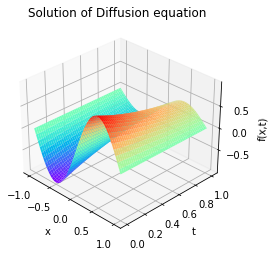

In [155]:
def fun_real(x, t):
    return np.exp(-t)*np.sin(pi*x)

total_points_x = 200
total_points_t = 100

x = np.linspace(xmin, xmax, total_points_x)
t = np.linspace(tmin, tmax, total_points_t)
X, T = np.meshgrid(x, t)

y_real = fun_real(X, T)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, T, y_real, cmap='rainbow')
ax.view_init(30, -45)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('f(x,t)')
ax.set_title('Solution of Diffusion equation')
plt.show()

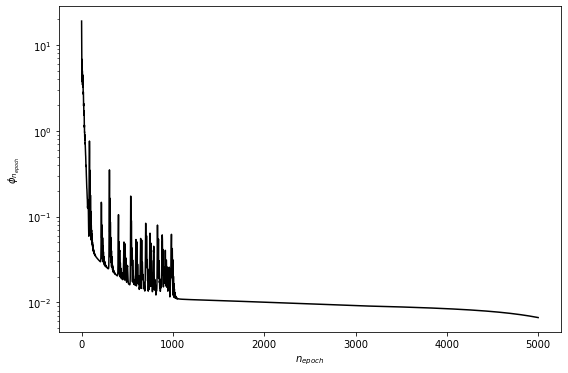

In [152]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');